In [1]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
import scipy as sp

import pymc3 as pm
import theano.tensor as tt


import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Primary resources for making this: 
https://docs.pymc.io/notebooks/GP-Marginal.html
https://github.com/fonnesbeck/gp_regression

Look into: 
https://docs.pymc.io/notebooks/posterior_predictive.html


In [2]:
map = True
dim = '3d'

if dim == '2d':
  data = np.genfromtxt('/content/drive/My Drive/data/gyro_fake_data_v0.csv', delimiter=',', skip_header=1)
elif dim == '3d':
  data = np.genfromtxt('/content/drive/My Drive/data/gyro_fake_data_v1.csv', delimiter=',', skip_header=1)


In [3]:
class Sqr_root(pm.gp.mean.Mean):
    '''Custom mean func of sqr root'''
    def __init__(self, coeffs=0, intercept=0):
        pm.gp.mean.Mean.__init__(self)
        self.b = intercept
        self.A = coeffs

    def __call__(self, X):
        return tt.squeeze(tt.dot(X**0.5, self.A) + self.b)
        #return tt.alloc(tt.add(tt.dot(tt.sqrt(X), self.A), self.B), X.shape[0])
     #   return tt.squeeze(tt.dot(X, self.A) + self.b)

In [4]:


y = data[:, 3]#[0::4] # Age
X1 = data[:, 1]#[0::4] # rotation
X2 = data[:, 2]#[0::4] # B-V 

Xs = np.array([X1, X2]).T
print(Xs.shape)
print(y.shape)



#nd = 20

#xu1, xu2 = np.meshgrid(np.linspace(np.amin(X1), np.amax(X1), nd), np.linspace(np.amin(X2), np.amax(X2), nd))
#Xu = np.concatenate([xu1.reshape(nd*nd, 1), xu2.reshape(nd*nd, 1)], 1).T
# array of inducing points - not too sure what this means but I think its used to reduce the number of input data points and thus computatioanl stress 


with pm.Model() as model:
    

    l1 = pm.Normal('l1', mu = 2.3, sigma=0.5)
    l2 = pm.Normal('l2', mu=25, sigma=5)

    sigmaf1 = pm.Normal('sigmaf1', mu=32, sigma= 2)
    sigmaf2 = pm.Normal('sigmaf2', mu=32, sigma = 2)

    sigman = pm.Normal('sigman', mu=1, sigma=0.5)

    #mean = Sqr_root((y/Xs).mean()) # This is where I have the best success
    #mean = pm.gp.mean.Constant(c=y.mean())
    mean = pm.gp.mean.Zero()

    K1 = pm.gp.cov.ExpQuad(2, l1) * sigmaf1**2
    K2 = pm.gp.cov.ExpQuad(2, l2) * sigmaf2**2

    #K = K1 * K2
    K = K1 + K2


    gp = pm.gp.Marginal(cov_func=K, mean_func=mean)
    obs = gp.marginal_likelihood("obs", X=Xs, y=y, noise=sigman)

    if map:
        mp = pm.find_MAP()
    



(1000, 2)
(1000,)


/usr/local/lib/python3.6/dist-packages/pymc3/tuning/starting.py:61: UserWarning: find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.
  warnings.warn('find_MAP should not be used to initialize the NUTS sampler, simply call pymc3.sample() and it will automatically initialize NUTS in a better way.')
WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.
logp = -1,842.5, ||grad|| = 76.546: 100%|██████████| 31/31 [00:19<00:00,  1.62it/s]  


In [5]:
if not map:
  with model:
    mp = pm.sample(100, tune=50, cores=1)
print(mp)

{'l1': array(0.79161268), 'l2': array(24.79441406), 'sigmaf1': array(40.08652509), 'sigmaf2': array(32.08776036), 'sigman': array(1.08885671)}


In [6]:
num_gen = 200

Xnew1 = np.linspace(np.amin(X1), np.amax(X1), num_gen)
Xnew2 = np.linspace(np.amin(X2), np.amax(X2), num_gen)

Xnew1, Xnew2 = np.meshgrid(Xnew1, Xnew2)

Xnew = np.stack((Xnew1, Xnew2)).T
Xnew_pred = Xnew.reshape(num_gen**2, 2)

#num_samples = 200
#with model:
 # f_pred = gp.conditional('f_pred1', Xnew_pred, pred_noise=False) # predict function
 # pred_samples = pm.sample_posterior_predictive([mp], vars=[f_pred], samples=num_samples) # predicts 1000 data points?

In [11]:
mu, var = gp.predict(Xnew_pred, point=mp, diag=True, pred_noise=False)

mu = mu.reshape(num_gen, num_gen).T
sd = np.sqrt(var)
sd = sd.reshape(num_gen, num_gen).T

No handles with labels found to put in legend.


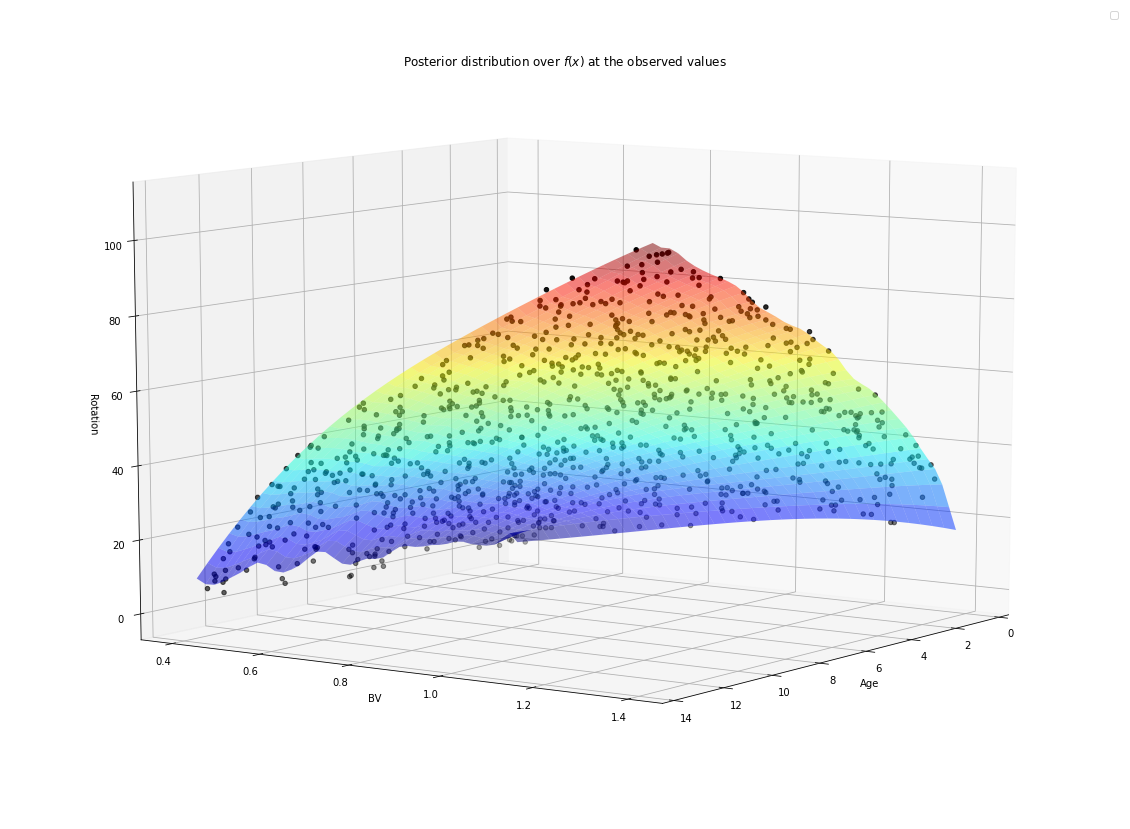

In [43]:
errorbars = False

fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')

from matplotlib import cm
from pymc3.gp.util import plot_gp_dist

if errorbars:
  for j in range(len(Xnew1)):
    for i in range(len(Xnew1)):
      plt.plot([Xnew1[i,j], Xnew1[i,j]], [Xnew2[i,j], Xnew2[i,j]], [mu[i,j] +sd[i,j], mu[i,j]-sd[i,j]], marker="_" )
      

ax.plot_surface(Xnew1, Xnew2, mu, alpha=0.5, cmap=cm.jet, linewidth=0.1)
ax.scatter(X1, X2, y, color='k')



# axis labels and title
plt.xlabel("Age")
plt.ylabel("BV")
ax.set_zlabel('Rotation')
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()
ax.view_init(10, 35)
plt.show()



